# 1. 基于 InceptionV3 的架构模型直接对狗的类别进行识别

In [1]:
import matplotlib.pyplot as plt
from keras.preprocessing import image
import numpy as np


def plot_bar(predictions):
    types = [pred[1] for pred in predictions]
    probs = [pred[2] for pred in predictions]
    
    plt.barh(np.arange(len(probs)), probs)
    _ = plt.yticks(np.arange(3), types)
    plt.show()
    

def load_img(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    return x

Using TensorFlow backend.


Predicted: [(u'n02089867', u'Walker_hound', 0.9321249), (u'n02089973', u'English_foxhound', 0.063430324), (u'n02088364', u'beagle', 0.0043542106)]


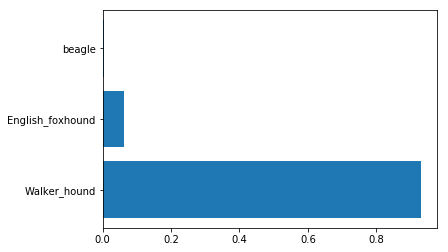

In [3]:
from keras.applications.inception_v3 import InceptionV3, preprocess_input, decode_predictions

def predicts_numbers():
    model = InceptionV3(weights='imagenet')

    img_path = "dog_test.png"
    x = load_img(img_path)
    x = preprocess_input(x)
    preds = model.predict(x)

    predictions = decode_predictions(preds, top=3)[0]
    print('Predicted: {}'.format(predictions))
    plot_bar(predictions)
  
predicts_numbers()

# 2. 基于 InceptionV3 的架构的迁移学习，对10种狗的类别进行识别

In [4]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

num_classes = 10

# 定义函数来加载train，test和validation数据集
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), num_classes)
    return dog_files, dog_targets

# 加载train，test和validation数据集
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# 加载狗品种列表
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

# 打印数据统计描述
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

There are 10 total dog categories.
There are 722 total dog images.

There are 578 training dog images.
There are 71 validation dog images.
There are 73 test dog images.


In [5]:
from keras.preprocessing import image   
from tqdm import tqdm

def path_to_tensor(img_path):
    # 用PIL加载RGB图像为PIL.Image.Image类型
    img = image.load_img(img_path, target_size=(224, 224))
    # 将PIL.Image.Image类型转化为格式为(224, 224, 3)的3维张量
    x = image.img_to_array(img)
    # 将3维张量转化为格式为(1, 224, 224, 3)的4维张量并返回
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)
                

from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True   

# Keras中的数据预处理过程
train_tensors = paths_to_tensor(train_files).astype(np.float32)/255
valid_tensors = paths_to_tensor(valid_files).astype(np.float32)/255
test_tensors = paths_to_tensor(test_files).astype(np.float32)/255

100%|██████████| 73/73 [00:01<00:00, 65.00it/s]


In [6]:
train_tensors.shape

(578, 224, 224, 3)

In [7]:
train_targets.shape

(578, 10)

In [5]:
# 参考：
# 迁移学习：https://keras.io/applications/
# fit_generator: https://keras.io/preprocessing/image/
# callback: https://keras.io/callbacks/


from keras.applications.inception_v3 import InceptionV3, preprocess_input, decode_predictions
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint  

import matplotlib.pyplot as plt


def add_new_last_layers(base_model, num_classes):
    # add a global spatial average pooling layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    # let's add a fully-connected layer
    x = Dense(1024, activation='relu')(x)

    # and a logistic layer -- let's say we have num_classes classes
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(input=base_model.input, output=predictions)
    return model


def freeze_previous_layers(model, base_model):
    # first: train only the top layers (which were randomly initialized)
    # i.e. freeze all convolutional InceptionV3 layers
    for layer in base_model.layers:
        layer.trainable = False

    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])


def fine_tune_model(model):
    # we chose to train the top 2 inception blocks, i.e. we will freeze
    # the first 249 layers and unfreeze the rest:
    for layer in model.layers[:172]:
        layer.trainable = False
    for layer in model.layers[172:]:
        layer.trainable = True

    model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
  
def plot_training(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, 'r.')
    plt.plot(epochs, val_acc, 'r')
    plt.title('Training and validation accuracy')

    plt.figure()
    plt.plot(epochs, loss, 'r.')
    plt.plot(epochs, val_loss, 'r-')
    plt.title('Training and validation loss')
    plt.show()

checkpointer = ModelCheckpoint(filepath='inceptin_v3.10dogs.weights.best1.h5', verbose=1, save_best_only=True)

def train(num_classes, batch_size, epochs):
  
    # data prep
    train_datagen = ImageDataGenerator(
      preprocessing_function=preprocess_input,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True
    )
    valid_datagen = ImageDataGenerator(
      preprocessing_function=preprocess_input,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True
    )

    # data augmentation
    train_generator = train_datagen.flow(train_tensors, train_targets, batch_size=batch_size)
    validation_generator = valid_datagen.flow(valid_tensors, valid_targets, batch_size=batch_size)

    # setup model
    # create the base pre-trained model
    base_model = InceptionV3(weights='imagenet', include_top=False) # include_top=False denotes that excludes final FC layer 
    model = add_new_last_layers(base_model, num_classes)

    # transfer learning
    freeze_previous_layers(model, base_model)

    print("First fitting the generator.")
    # train the model on the new data for a few epochs
    history_tl = model.fit_generator(train_generator, 
                      steps_per_epoch=train_tensors.shape[0] / batch_size, 
                      epochs=epochs,
                      verbose=1, 
                      callbacks=[checkpointer], 
                      validation_data=validation_generator)

    # fine tune
    fine_tune_model(model)

    print("Second fitting the generator.")
    # we train our model again (this time fine-tuning the top 2 inception blocks
    # alongside the top Dense layers
    history_ft = model.fit_generator(train_generator, 
                      steps_per_epoch=valid_tensors.shape[0] / batch_size, 
                      epochs=epochs,
                      verbose=1, 
                      callbacks=[checkpointer], 
                      validation_data=validation_generator)


    # https://machinelearningmastery.com/save-load-keras-deep-learning-models/
    # serialize model to YAML
    model_yaml = model.to_yaml()
    with open("inceptin_v3_10dogs_weights_best.yaml", "w") as yaml_file:
        yaml_file.write(model_yaml)
    # serialize weights to HDF5 
    model.save_weights("inceptin_v3_10dogs_weights_best.h5")
    print("Saved model to disk")

    plot_training(history_ft)


batch_size = 128
epochs = 1
train(num_classes, batch_size, epochs)


/Users/victor/virtualenvlist/mydlp2/lib/python2.7/site-packages/ipykernel_launcher.py:23: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`


Epoch 1/10
9/9 [==============================] - 85s 9s/step - loss: 6.3703 - acc: 0.3102 - val_loss: 2.5822 - val_acc: 0.1127

Epoch 00001: val_loss improved from inf to 2.58215, saving model to inceptin_v3.10dogs.weights.best.h5
Epoch 2/10
9/9 [==============================] - 88s 10s/step - loss: 2.2321 - acc: 0.5306 - val_loss: 2.3245 - val_acc: 0.1549

Epoch 00002: val_loss improved from 2.58215 to 2.32450, saving model to inceptin_v3.10dogs.weights.best.h5
Epoch 3/10
9/9 [==============================] - 88s 10s/step - loss: 2.3006 - acc: 0.6107 - val_loss: 2.3425 - val_acc: 0.1268

Epoch 00003: val_loss did not improve from 2.32450
Epoch 4/10
9/9 [==============================] - 89s 10s/step - loss: 1.0526 - acc: 0.7259 - val_loss: 2.5016 - val_acc: 0.1408

Epoch 00004: val_loss did not improve from 2.32450
Epoch 5/10
9/9 [==============================] - 90s 10s/step - loss: 2.1137 - acc: 0.6132 - val_loss: 2.7327 - val_acc: 0.0845

Epoch 00005: val_loss did not improve f

NameError: global name 'plot_training' is not defined

# 通过hdf5权重来加载InceptionV3的迁移学习模型

> HDF5文件是用来保存模型的权重

预测步骤：
- 1.创建模型架构，从InceptionV3桥接过来的
- 2.加载模型权重
- 3.预测

In [47]:
from keras.models import Sequential
from keras.layers import Dense, Activation

base_model = InceptionV3(weights='imagenet', include_top=False,input_shape=test_tensors.shape[1:]) 
trained_model = add_new_last_layers(base_model, 10)

trained_model.load_weights("inceptin_v3.10dogs.weights.best.h5") # load weights into new model
trained_model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
#trained_model.summary()

score = trained_model.evaluate(test_tensors, test_targets, verbose=1)
print("Test {}: {:.2f}. Test {}: {:.2f}.".format(trained_model.metrics_names[0], 
                                                 score[0]*100, 
                                                 trained_model.metrics_names[1], 
                                                 score[1]*100))

/Users/victor/virtualenvlist/mydlp2/lib/python2.7/site-packages/ipykernel_launcher.py:23: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`


73/73 [==============================] - 18s 249ms/step
Test loss: 31.04. Test acc: 87.67.


Predicted: [[1.8175404e-05 8.1746082e-05 1.1727394e-05 6.1724364e-05 1.2665604e-05
  1.7824543e-05 9.9977142e-01 1.6615742e-05 3.7802827e-06 4.3137570e-06]]


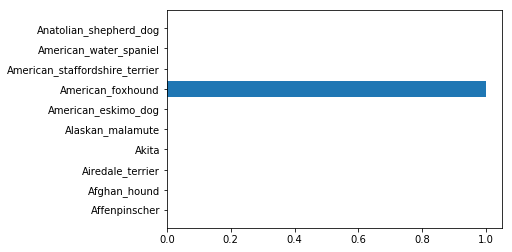

In [70]:
# 预测真实狗狗的图片

def load_dog_img(trained_model):
    img_path = 'dog_test.png' #'dogImages/test/007.American_foxhound/American_foxhound_00519.jpg'
    x = load_img(img_path)
    x = preprocess_input(x)
    predictions = trained_model.predict(x)

    #predictions = decode_predictions(predictions, top=10)
    print('Predicted: {}'.format(predictions))

    plt.barh(np.arange(10), predictions[0])
    _ = plt.yticks(np.arange(10), dog_names)
    plt.show()

load_dog_img(trained_model)

# 通过.yaml文件和.hdf5文件来加载InceptionV3的迁移学习模型

> yaml文件和json文件都可以保存模型的架构

> HDF5文件用来保存模型的权重

预测步骤：
- 1.加载模型架构
- 2.加载模型权重
- 3.预测

In [22]:
# 验证

# https://machinelearningmastery.com/save-load-keras-deep-learning-models/

# load YAML and create model
with open('model.yaml', 'r') as yaml_file:
  loaded_model_yaml = yaml_file.read()
loaded_model = model_from_yaml(loaded_model_yaml)

# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
score = loaded_model.evaluate(X_train, y_train, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))



73/73 [==============================] - 13s 176ms/step
Test loss: 31.04. Test acc: 87.67.
